In [10]:
%load_ext autoreload
%autoreload 2


import os
import sys
import glob
import torch
import json
import pandas as pd
import time
import qgrid
import torch


from pytorch_utils.logging import LoggerReader
from pytorch_utils.collection_utils import keychain_value_iter
from collections import defaultdict, OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
# import mpld3
# mpld3.enable_notebook()
%matplotlib inline

from nb_common import load_results


DEVICE = 'cuda:2'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# root = Path('/scratch2/chofer/toporeg_sandbox/'

# root = Path('/tmp/tmp_results')
# root = Path('/tmp/testing')
root = Path('/tmp/debug')
#root = Path('/tmp/grid_1')


# root = Path('/home/pma/chofer/repositories/toporeg_sandbox/results_energy/')


In [76]:
args_white_list = {
    'num_runs', 
    'num_samples', 
    'num_batches',
    'num_sub_batches',
    'size_sub_batch',
    'tag', 
    'eval_interval',
    'model', 
    'lr_init',
    'weight_decay',
    'ds_train',
    'ds_test' ,
    'momentum',
    'augment',
    'losses',
    'w_losses',
}

# tag='spectral_norm'
tag = None


def progress(logger_reader):
    n_runs = len(logger_reader)
    
    if len(logger_reader) == 0 or 'batch_i' not in logger_reader:
        return "not started"    
    
    n_batches = logger_reader[-1]["batch_i"]+1        
        
    args = logger_reader.experiment_args
    
    if n_runs == args['num_runs'] and n_batches == args['num_batches']:
        return True
    else:
        s = '{}/{}'.format(n_runs, str(args['num_runs']))
        s += ' {:.2%} '.format(n_batches/float(args['num_batches']))
        return s
    

def args_df_from_results():
    RESULTS = load_results(root, tag=tag)
    R = []
    
    for i, r in enumerate(RESULTS):
        
        df = {k: str(v) if isinstance(v, (list, tuple)) else v for  k, v in r.experiment_args.items() if k in args_white_list}
        df['experiment'] = r.experiment_args['experiment_type']
        df['date'] = r.date
        df = pd.DataFrame(df, index=[i]) 
        df['progress'] = progress(r)
        
        R.append(df)   
        
    return pd.concat(R, sort=False)


def progress_from_results():
    RESULTS = load_results(root, tag=tag)
    
    tmp = defaultdict(list)
    
    for i, r in enumerate(RESULTS):
        
        p = progress(r)
        
        if isinstance(p, str):
            tmp['Idx'].append(i)
            tmp['progress'].append(p)
            tmp['path'].append(r.path)
            
    return pd.DataFrame(tmp)
    

def df_from_results():
    RESULTS = load_results(root, tag=tag)
    A = args_df_from_results()
    
    tmp = []
    for i, r in enumerate(RESULTS):
        df = {}
        for k in [
            'linear_train',
            'linear_test',
            'retrained_linear_train',
            'retrained_linear_test',
            'explicit_linear_train', 
            'explicit_linear_test'        
        ]:
            try:
                df[k] = np.mean([run[k][-1] for run in r])
                
            except KeyError:
                pass
            
        tmp.append(pd.DataFrame(df, index=[i]))
    
    B = pd.concat(tmp, sort=False)
    return A.join(B) 

In [77]:
def plt_losses(idx,from_batch_i=0):
    RESULTS = load_results(root, tag=tag)
    plt.figure() 
    
    r = RESULTS[idx][0] 
    
    for k, v in r.items():
        
        if 'batch_' in k and k not in ['batch_cls_loss', 'batch_i']:
            
            plt.plot(r[k][from_batch_i:], label=k.split('batch_')[1], alpha=0.5)
            
    plt.legend()
    plt.grid()

In [78]:
progress_from_results()

,Idx,progress,path
0,0,not started,/tmp/debug/11-10-2020-07-31-18__a32bad45-e705-...
1,1,not started,/tmp/debug/11-10-2020-07-57-50__f36dcade-b734-...
2,2,not started,/tmp/debug/11-10-2020-08-01-34__7643c653-0b3a-...
3,3,not started,/tmp/debug/11-10-2020-08-29-52__59af3254-86fe-...
4,4,not started,/tmp/debug/11-10-2020-08-30-25__45c1759e-885b-...


In [79]:
#RESULTS[31].path

In [80]:
args_df_from_results()

,num_batches,tag,eval_interval,num_runs,num_samples,model,lr_init,weight_decay,ds_train,ds_test,momentum,augment,num_sub_batches,size_sub_batch,losses,w_losses,experiment,date,progress
0,100,,100,1,None,"['ResNet18', {'compactification': 'sphere_l2',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,1,256,"[['SupConLoss', {'temperature': 0.1}]]",None,core.experiment.Experiment,2020-11-10 07:31:18,not started
1,10000,,10000,1,None,"['ResNet18', {'compactification': 'sphere_l2',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,1,256,"[['SupConLossWeighted', {'temperature': 0.1, '...",None,core.experiment.Experiment,2020-11-10 07:57:50,not started
2,10000,,10000,1,1000,"['ResNet18', {'compactification': 'sphere_l2',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,1,256,"[['SupConLossWeighted', {'temperature': 0.1, '...",None,core.experiment.Experiment,2020-11-10 08:01:34,not started
3,1000,,1000,1,1000,"['ResNet18', {'compactification': 'sphere_l2',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,1,256,"[['SupConLossWeighted', {'temperature': 0.1, '...",None,core.experiment.Experiment,2020-11-10 08:29:52,not started
4,1000,,1000,1,1000,"['ResNet18', {'compactification': 'sphere_l2',...",0.1,0.0001,cifar10_train,cifar10_test,0.9,none,1,256,"[['SupConLossWeighted', {'temperature': 0.1, '...",None,core.experiment.Experiment,2020-11-10 08:30:25,not started


In [83]:
qgrid_widget = qgrid.show_grid(df_from_results(), show_toolbar=True)
qgrid_widget

/scratch2/chofer/opt/anaconda3/envs/pyt_1.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch2/chofer/opt/anaconda3/envs/pyt_1.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [376]:
# rkwitt
def plot_multiple_losses(idxs,from_batch_i=0):
    RESULTS = load_results(root, tag=tag)
    plt.figure() 
    
    for idx in idxs:
        
        r = RESULTS[idx][0] 

        for k, v in r.items():

            if 'batch_' in k and k not in ['batch_cls_loss', 'batch_i']:

                plt.plot(r[k][from_batch_i:], label=k.split('batch_')[1] + '_{}'.format(idx))

    plt.legend()
    plt.grid()

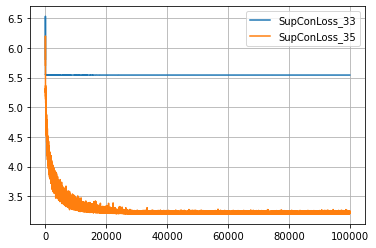

In [383]:
plot_multiple_losses([33,35], from_batch_i=0)

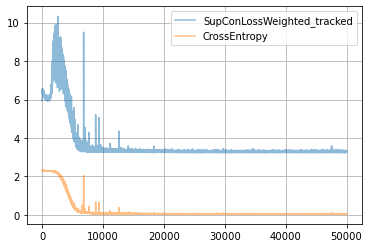

In [381]:
plt_losses(-3, from_batch_i=0)
# plt.gca().set_ylim((0, 3))
# plt.gca().plot([0, 40000],[np.log(10), np.log(10)])

In [382]:
load_results(root)[-3].experiment_args

{'num_runs': 1,
 'output_root_dir': '/tmp/testing/',
 'num_batches': 50000,
 'augment': 'none',
 'tag': '',
 'model': ['SimpleCNN13',
  {'batch_norm': True,
   'drop_out': False,
   'final_bn': True,
   'compactification': 'sphere_l2',
   'linear_bias': False,
   'cls_norm': 'none',
   'latent_dim': None}],
 'batch_cfg': [256, {'+': 1, '-': 0}],
 'lr_init': 0.1,
 'momentum': 0.0,
 'weight_decay': 0.001,
 'ds_train': 'cifar10_train',
 'ds_test': 'cifar10_test',
 'energies': [['CrossEntropy', {}]],
 'energies_track_only': [['SupConLossWeighted',
   {'temperature': 0.1, 'weight': 1.0}]],
 'w_energies': None,
 'eval_interval': 50000,
 'evaluation_policies': ['optimized_linear', 'explicit_linear'],
 'experiment_type': 'core.experiment_energy.ExpEnergyRandomLabeledData'}

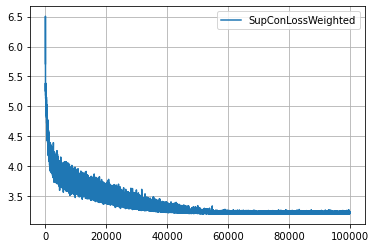

In [102]:
plt_losses(-4, from_batch_i=0)

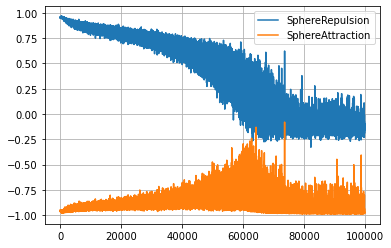

In [330]:
plt_losses(6, from_batch_i=100)

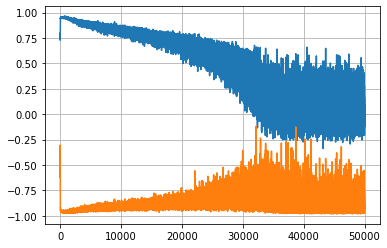

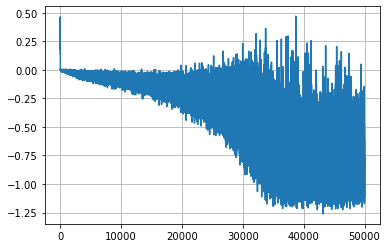

In [297]:
idx = 2

plt.figure()
plt.plot(RESULTS[idx][0]['batch_SphereRepulsion'])
plt.plot(RESULTS[idx][0]['batch_SphereAttraction'])
plt.grid()

plt.figure()
Y = np.array(RESULTS[idx][0]['batch_SphereRepulsion'])
Y += np.array(RESULTS[idx][0]['batch_SphereAttraction'])
plt.plot(Y)
plt.grid()

In [356]:
R = load_results(root)
for idx in [1, 11]:
    m = R[idx].load_model(0, 'optimized_linear')
    print(m.weight.data.norm(p=2, dim=1))
    

tensor([2.9218, 2.9174, 2.9175, 2.9161, 2.9200, 2.9191, 2.9157, 2.9195, 2.9171,
        2.9194])
tensor([1.2652, 1.2491, 1.2752, 1.2764, 1.2690, 1.2716, 1.2627, 1.2585, 1.2604,
        1.2600])


In [59]:
load_results(root)[0][0].keys() #['retrained_linear_train']

dict_keys(['linear_test', 'explicit_linear_train', 'linear_train', 'optimized_linear_loss', 'optimized_linear_test', 'optimized_linear_train', 'batch_CrossEntropy', 'explicit_linear_test', 'batch_i'])